In [8]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import csv
import time
import os
import sys
import importlib
import torch
import cv2
from IPython.display import clear_output


def create_directory_if_not_exists(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

def list_files(directory):
    files = []
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.is_file():
                files.append(f"{entry.name}")
    return files

# 元データのディレクトリ
origin_img_path = "/root/dataset/selfie2anime/trainB"

# 仕分けしたデータセットのディレクトリ
datasets_dir = "/root/dataset/original_dataset/selfie2anime_200-300"
divided_data_path = f"{datasets_dir}/images"
unused_data_path = f"{datasets_dir}/unused"
annotations_data_path = f"{datasets_dir}/annotations"

for path in [divided_data_path,unused_data_path,annotations_data_path]:
    dir_name = ""
    for dir in path.split("/"):
        dir_name += dir + "/"
        create_directory_if_not_exists(dir_name)


In [6]:
all_images = list_files(f"{origin_img_path}")
all_images.sort()
# /root/source/deeplearning_trainer/models
model_file = "/root/source/deeplearning_trainer/models"
MODEL_FILE = "resnet"
sys.path.append(model_file)
module = importlib.import_module(MODEL_FILE)
DEVICE = torch.device(f'cuda:1' if torch.cuda.is_available() else 'cpu')
model = module.LandmarkDetector().to(DEVICE)

# model_path = "/root/Cloud/deeplearning_results/mlruns/934808299413314277/4a989e3acd194098938c07408757cdb1/artifacts/models/model_epoch_10000.pth"
# model_path = "/root/Cloud/deeplearning_results/mlruns/934808299413314277/703368fe716f4fe280b94aef9e630500/artifacts/models/model_epoch_10000.pth"
model_path = "/root/Cloud/deeplearning_results/mlruns/667748090728499231/cf7f2f5185ef4fc980a7685fd4369d1c/artifacts/models/model_epoch_5000.pth"


RESIZE = 256

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


ResNet(
  (conv1): Conv2d(3, 3, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(6

0299.jpg
original size
(256, 256, 3)
new_width,new_height
332 332
cropped_image.shape
(256, 256, 3)


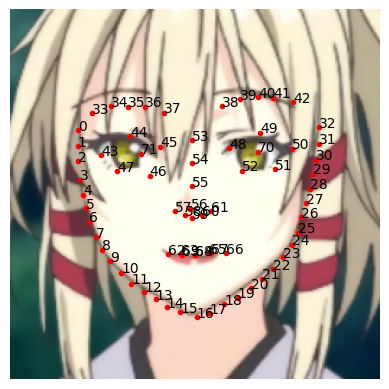

/root/dataset/original_dataset/selfie2anime_200-300/images/0299.jpg


In [10]:
for image_name in all_images[200:300]:
    print(image_name)
    with torch.no_grad():
        image = cv2.imread(f"{origin_img_path}/{image_name}")
        print("original size")
        print(image.shape)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        orig_image = image.copy()
        height,width,_ = orig_image.shape

        # 画像を拡大してクロップする
        scale_factor = 1.3
        new_height = int(height * scale_factor)
        new_width = int(width * scale_factor)
        # 拡大
        resized_image = cv2.resize(image, (new_width, new_height))
        # クロップする範囲を計算
        crop_x1 = (new_width - width) // 2
        crop_x2 = crop_x1 + width
        crop_y1 = (new_height - height) // 2
        crop_y2 = crop_y1 + height
        # クロップ（切り取り）
        cropped_image = resized_image[crop_y1:crop_y2, crop_x1:crop_x2]

        input_image = cropped_image.copy()
        shape_y,shape_x,_ = input_image.shape

        input_image = cv2.resize(input_image, (RESIZE, RESIZE))
        # print("cv2.resize直後:",image.shape)
        input_image = input_image / 255.0
        input_image = np.transpose(input_image, (2, 0, 1))
        # image = np.transpose(image)
        # print("cv2.resize直後:",input_image.shape)
        input_image = torch.tensor(input_image, dtype=torch.float)
        input_image = input_image.unsqueeze(0).to(DEVICE)
        outputs = model(input_image)
        # print(outputs)
        outputs = outputs.cpu().detach().numpy()
        outputs = outputs.reshape(-1, 2)

        plt.imshow(cropped_image, cmap='gray')
        print("new_width,new_height")
        print(new_width,new_height)
        print("cropped_image.shape")
        print(cropped_image.shape)
        keypoints = outputs * [cropped_image.shape[0],cropped_image.shape[0]]

        for p in range(keypoints.shape[0]):
            plt.plot(keypoints[p, 0], keypoints[p, 1], 'r.')
            plt.text(keypoints[p, 0], keypoints[p, 1], f"{p}")
        plt.axis('off')

        # print(keypoints)

        # image_name = image_name.replace("images/","")
        # plt.savefig(f"{save_image_dir}/valid_{image_name}")
        plt.show()
        plt.close()

        # キー入力でデータセットとして利用可能か判断する
        two_dim_array = np.array(keypoints)
        one_dim_array = two_dim_array.flatten()
        image_landmark = [image_name] + one_dim_array.tolist()
        # csv_row.append()
        # print(csv_row)
        # key_input = input()
        with open(f"{annotations_data_path}/annotations.csv","a") as f:
            writer = csv.writer(f)
            writer.writerow(image_landmark)
        print(f"{divided_data_path}/{image_name}")
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        cv2.imwrite(f"{divided_data_path}/{image_name}",cropped_image)
        # cropped_image.save(f"{divided_data_path}/{cropped_image}")
    time.sleep(0.5)
    clear_output(True)
